<a href="https://colab.research.google.com/github/ikaurrr/Project-A-Study-of-Cascading-Failures-in-Real-and-Synthetic-Power-Grid-Topologies/blob/main/Exploratory_Data_Analysis_of_Power_Grid_Data_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  DADA(Distance and Degree Attachment model) For synthetic Power Grid
Reference:  A Study of Cascading Failures in Real and
 Synthetic Power Grid Topologies

## Installing and Importing Necessary Libraries

In [1]:
#!pip install numpy
#!pip install networkx
#!pip install matplotlib
#!pip install pandas
#!pip install scipy
#!pip install power-grid-model

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


In [3]:
def generate_dada_network(n, l, mu=6, rho=1):
    """
    Generates a Degree And Distance Attachment (DADA) model network.

    Parameters:
    n (int): Number of nodes.
    l (int): Target number of edges in the network.
    mu (float): Distance penalty factor; higher values discourage long-distance connections.
    rho (float): Resistivity factor for edges.

    Returns:
    dada (nx.Graph): Generated network with n nodes and approximately l edges.
    """

    # Initialize an empty graph
    dada = nx.Graph()

    # Generate node positions on a 2D plane with uniform random distribution
    positions = {i: (np.random.rand(), np.random.rand()) for i in range(n)}

    # Add nodes to the graph
    dada.add_nodes_from(range(n))

    # Pre-compute average degree and integer connections per node
    avg_degree = l / n
    num_connections = {i: int(avg_degree) for i in range(n)}
    extra_connections = l - sum(num_connections.values())

    # Distribute additional connections randomly
    for i in np.random.choice(range(n), extra_connections, replace=False):
        num_connections[i] += 1

    # Helper function to calculate distance between two nodes
    def distance(i, j):
        return np.sqrt((positions[i][0] - positions[j][0]) ** 2 + (positions[i][1] - positions[j][1]) ** 2)

    # Iterate over nodes to connect them based on DADA model
    for j in range(1, n):
        possible_edges = []
        for i in range(j):  # Consider only nodes that are already in the network
            dist = distance(i, j)
            prob = dada.degree[i] / (dist ** mu) if dist != 0 else 0
            possible_edges.append((i, j, prob, dist))

        # Sort by probability (high to low) and select top connections based on num_connections[j]
        possible_edges = sorted(possible_edges, key=lambda x: x[2], reverse=True)
        for edge in possible_edges[:num_connections[j]]:
            i, j, _, dist = edge
            dada.add_edge(i, j, resistance=rho * dist)

    return dada, positions



In [4]:
def plot_network(dada, positions, title="DADA Model Network"):
    """
    Plots the generated network with positions.

    Parameters:
    dada (nx.Graph): The graph to be plotted.
    positions (dict): Node positions in a 2D plane.
    title (str): Title for the plot.
    """
    plt.figure(figsize=(8, 8))
    nx.draw(dada, pos=positions, node_size=50, with_labels=False, edge_color="skyblue", node_color="orange")
    plt.title(title)
    plt.show()



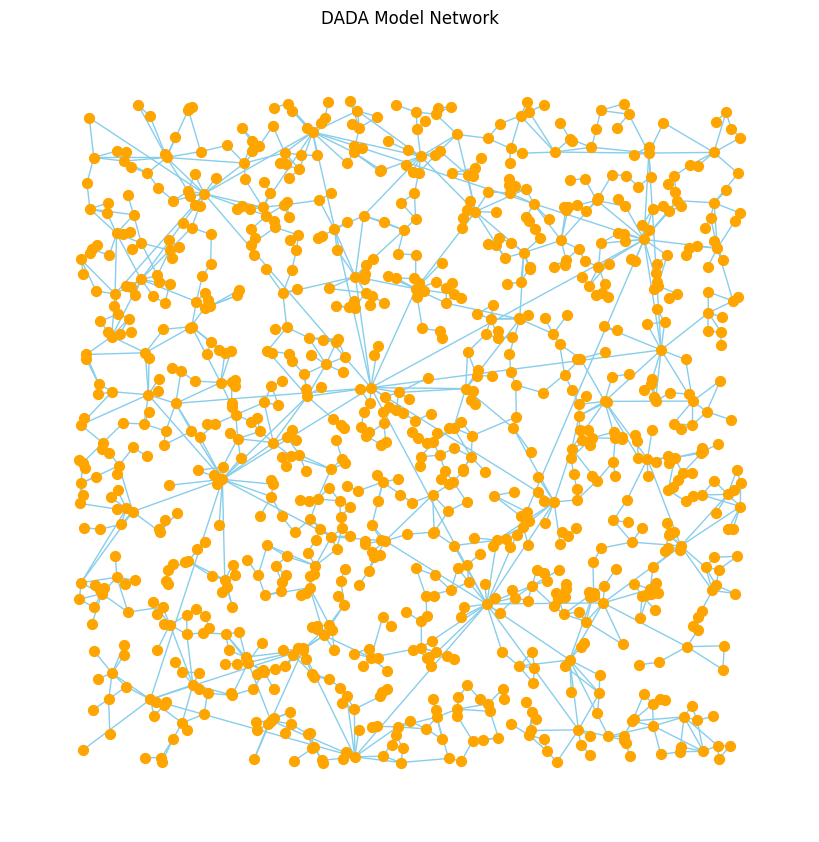

In [5]:
# Parameters
n = 1000  # Number of nodes
l = 1500  # Target number of edges
mu = 5  # Distance penalty
rho = 1  # Resistivity

# Generate the network
dada, positions = generate_dada_network(n, l, mu, rho)

# Plot the generated network
plot_network(dada, positions)


In [6]:
import numpy as np

# Parameters based on the USWI data
n = 13135           # Total number of nodes
n_plus = 1197       # Number of supply nodes
n_minus = 3888      # Number of demand nodes

# Distribution parameters for supplies and demands
sigma_plus = 2.0
m_plus = 0.38924
a_plus = 1.6

sigma_minus = 1.8
m_minus = 0.62826
a_minus = 1.2

# Randomly select supply and demand nodes
all_nodes = np.arange(n)
supply_nodes = np.random.choice(all_nodes, n_plus, replace=False)
remaining_nodes = np.setdiff1d(all_nodes, supply_nodes)
demand_nodes = np.random.choice(remaining_nodes, n_minus, replace=False)

# Example: node degrees in the DADA model (for simplicity, generate random degrees)
node_degrees = np.random.randint(1, 20, size=n)  # Replace with actual degree data if available

# Generate supply and demand currents following a modified lognormal distribution
supply_currents = np.zeros(n)  # Array to store supply currents for all nodes
demand_currents = np.zeros(n)  # Array to store demand currents for all nodes

# Generate supply currents (I+)
for i in supply_nodes:
    # Randomly sample from a normal distribution
    nu_i = np.random.normal()
    # Calculate I+ based on the modified lognormal distribution and apply cut-off
    supply_current = np.exp(nu_i * sigma_plus + m_plus * np.log(node_degrees[i]))
    supply_currents[i] = min(supply_current, np.exp(a_plus * sigma_plus))

# Generate demand currents (I-)
for i in demand_nodes:
    # Randomly sample from a normal distribution
    nu_i = np.random.normal()
    # Calculate I- based on the modified lognormal distribution and apply cut-off
    demand_current = np.exp(nu_i * sigma_minus + m_minus * np.log(node_degrees[i]))
    demand_currents[i] = min(demand_current, np.exp(a_minus * sigma_minus))

# Check results
print("Sample of supply currents:", supply_currents[supply_currents > 0][:10])
print("Sample of demand currents:", demand_currents[demand_currents > 0][:10])


Sample of supply currents: [24.5325302  24.5325302   0.69882365 19.28279456  0.67802333  0.57953747
 12.87789108 24.5325302  24.5325302   0.17219785]
Sample of demand currents: [8.67113766 1.37146069 1.22608594 7.66226118 4.60755983 0.20348632
 0.24879231 0.52520126 2.65835505 1.19512275]


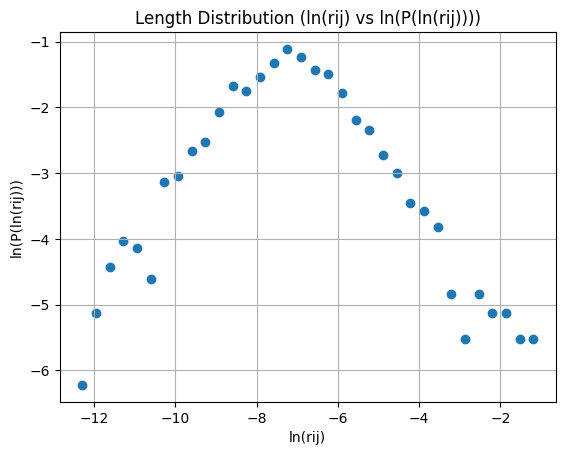

In [7]:
def analyze_length_distribution(G, positions):
  """
  Analyzes the length distribution of the network and plots ln(rij) vs ln(P(ln(rij)))

  Args:
      G (nx.Graph): The generated network.
      positions (dict): Node positions.
  """

  edge_lengths = []
  for edge in G.edges():
    i, j = edge
    edge_lengths.append((np.linalg.norm(np.array(positions[i]) - np.array(positions[j])))**2)


  # Calculate the logarithm of edge lengths
  ln_edge_lengths = np.log(edge_lengths)

  # Calculate the probability distribution of log-edge lengths
  hist, bin_edges = np.histogram(ln_edge_lengths, bins='auto', density=True)
  bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
  ln_hist = np.log(hist)

  # Plot ln(rij) vs ln(P(ln(rij)))
  plt.figure()
  plt.scatter(bin_centers, ln_hist)
  plt.xlabel("ln(rij)")
  plt.ylabel("ln(P(ln(rij)))")
  plt.title("Length Distribution (ln(rij) vs ln(P(ln(rij))))")
  plt.grid(True)
  plt.show()



# Analyze and plot the length distribution
analyze_length_distribution(dada, positions)

# Generate Supply and Demand

# Synthetic Power Grid similar to USWI
Reference:  A Learning-based Method for
 Generating Synthetic Power Grids
 Saleh Soltan, Member, IEEE, Alexander Loh, Student Member, IEEE, and Gil Zussman, Senior Member, IEEE

In [8]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the data from CSV files
bus_locations = pd.read_csv('/content/Gen_WI_Bus_Locations.csv')
lines = pd.read_csv('/content/Gen_WI_Lines.csv')
supply_values = pd.read_csv('/content/Gen_WI_Supply_Values.csv')
demand_values = pd.read_csv('/content/Gen_WI_Demand_Values.csv')

def print_dataframes_head():
  """Prints the head of each dataframe loaded from CSV files."""


  print("Bus Locations:")
  print(bus_locations.head())
  print("\nLines:")
  print(lines.head())
  print("\nSupply Values:")
  print(supply_values.head())
  print("\nDemand Values:")
  print(demand_values.head())

# Call the function to print the heads of the dataframes
print_dataframes_head()

Bus Locations:
   Bus Number         Lon        Lat
0           1 -114.808295  33.285811
1           2 -109.168098  45.131739
2           3 -118.686391  36.191126
3           4 -122.776463  49.148646
4           5 -106.566784  45.765771

Lines:
   Line Number  Bus 1  Bus 2         x
0            1  14430  13769  0.176627
1            2  14429  13074  0.102980
2            3  14428  14036  0.084389
3            4  14427  14007  0.011286
4            5  14426  12302  0.137005

Supply Values:
   Bus Number  Supply (MW)
0           1          0.0
1           2          0.0
2           3          0.0
3           4          0.0
4           5          0.0

Demand Values:
   Bus Number  Demand (MW)
0           1          0.0
1           2          0.0
2           3          0.0
3           4          0.0
4           5          0.0


# Power Grid Data Description

This data consists of four tables, each contained in a single comma-delimited CSV file. The files describe data regarding the buses and lines in the synthetic network generated based off of the Western Interconnection (WI), as in the paper. The data is organized as follows:

## 1. **Gen_WI_Bus_Locations.csv**
This file describes the location of each bus in the generated network. Each row in the table contains three fields:
- **Bus Number**: The unique identifier for each bus.
- **Lon**: The longitude of the bus in degrees.
- **Lat**: The latitude of the bus in degrees.

Bus numbers are reused between tables, so a particular bus number corresponds to the same bus in each table.

## 2. **Gen_WI_Lines.csv**
This file describes the lines going between different pairs of buses in the generated network. Each row contains four fields:
- **Line Number**: The unique identifier for each transmission line.
- **Bus 1**: The bus number at one end of the line.
- **Bus 2**: The bus number at the other end of the line.
- **x**: The length of the line, which can be used as the reactance value of the line.

## 3. **Gen_WI_Supply_Values.csv**
This file describes the supply at each node in the generated network. Supplies are determined by connecting each generator in the WI to its nearest neighboring bus, and summing the supplies at each bus. Each row contains two fields:
- **Bus Number**: The bus number where the supply is located.
- **Supply**: The supply at the bus in megawatts.

## 4. **Gen_WI_Demand_Values.csv**
This file describes the demand at each node in the generated network. Supplies are determined by connecting each town in the WI to its nearest neighboring bus, and summing the corresponding estimated demand at each bus. Each row contains two fields:
- **Bus Number**: The bus number where the demand is located.
- **Demand**: The demand at the bus in megawatts.

paper:  A Learning-based Method for
 Generating Synthetic Power Grids
 Saleh Soltan, Member, IEEE, Alexander Loh, Student Member, IEEE, and Gil Zussman, Senior Member, IEEE

In [9]:
# Step 2: Create an empty network graph
G = nx.Graph()

In [10]:
# Step 3: Add nodes to the graph with geographical locations (longitude and latitude)
for _, row in bus_locations.iterrows():
    bus_number = row['Bus Number']
    G.add_node(bus_number, lon=row['Lon'], lat=row['Lat'])


In [11]:
# Step 4: Add edges to the graph based on the lines
for _, row in lines.iterrows():
    bus1 = row['Bus 1']
    bus2 = row['Bus 2']
    reactance = row['x']
    G.add_edge(bus1, bus2, reactance=reactance)

In [12]:
supply_values.head()

,Bus Number,Supply (MW)
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [13]:
non_zero_rows = supply_values[supply_values['Supply (MW)'] != 0]
count = non_zero_rows.shape[0]
print("Number of rows with non-zero supply values:", count)

Number of rows with non-zero supply values: 3058


In [14]:
# Step 5: Add supply and demand values to the nodes
for _, row in supply_values.iterrows():
    bus_number = row['Bus Number']
    supply = row['Supply (MW)']
    G.nodes[bus_number]['supply'] = supply

In [15]:
demand_values.head()

,Bus Number,Demand (MW)
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [16]:
non_zero_rows = demand_values[demand_values['Demand (MW)'] != 0]
count = non_zero_rows.shape[0]
print("Number of rows with non-zero demand values:", count)

Number of rows with non-zero demand values: 3095


In [17]:
for _, row in demand_values.iterrows():
    bus_number = row['Bus Number']
    demand = row['Demand (MW)']
    G.nodes[bus_number]['demand'] = demand




In [18]:
# Count total number of nodes
total_nodes = G.number_of_nodes()


num_supply_nodes = len(supply_nodes)
num_demand_nodes = len(demand_nodes)

# Count number of transmission lines (edges)
num_lines = G.number_of_edges()

# Calculate average degree of each node
average_degree = sum(degree for _, degree in G.degree()) / total_nodes

# Calculate average degree of supply nodes (consider handling empty lists)
if num_supply_nodes > 0:
  average_degree_supply = sum(G.degree(node) for node in supply_nodes) / num_supply_nodes
else:
  average_degree_supply = 0  # Handle empty list case

# Calculate average degree of demand nodes (consider handling empty lists)
if num_demand_nodes > 0:
  average_degree_demand = sum(G.degree(node) for node in demand_nodes) / num_demand_nodes
else:
  average_degree_demand = 0  # Handle empty list case

# Print the results
print("Total number of nodes:", total_nodes)
print("Number of supply nodes:", num_supply_nodes)
print("Number of demand nodes:", num_demand_nodes)
print("Number of transmission lines:", num_lines)
print("Average degree of each node:", average_degree)
print("Average degree of supply nodes:", average_degree_supply)
print("Average degree of demand nodes:", average_degree_demand)

transmitting_nodes = [bus for bus, data in G.nodes(data=True) if data.get('supply', 0) == 0 and data.get('demand', 0) == 0]

# Count transmitting nodes
transmitting_node_count = len(transmitting_nodes)
print(f"Number of transmitting nodes: {transmitting_node_count}")

Total number of nodes: 14430
Number of supply nodes: 1197
Number of demand nodes: 3888
Number of transmission lines: 16786
Average degree of each node: 2.3265419265419265
Average degree of supply nodes: 2.3909774436090228
Average degree of demand nodes: 2.4027777777777777
Number of transmitting nodes: 8277


In [19]:
for node, data in G.nodes(data=True):
    print(node, data)

# Initialize initial_demand from the graph's node data
initial_demand = {node: data.get("demand", 0.0) for node, data in G.nodes(data=True)}

# Verify initial_demand
print("Initial Demand:")
for node, demand in initial_demand.items():
    print(f"Node {node}: Demand {demand}")

Streaming output truncated to the last 5000 lines.
Node 9431.0: Demand 2.281793451
Node 9432.0: Demand 2.688973278
Node 9433.0: Demand 3.825903966
Node 9434.0: Demand 3.944885085
Node 9435.0: Demand 37.60596552
Node 9436.0: Demand 4.640263622
Node 9437.0: Demand 1.208319359
Node 9438.0: Demand 4.574163
Node 9439.0: Demand 0.293486759
Node 9440.0: Demand 1.660447609
Node 9441.0: Demand 1.607567112
Node 9442.0: Demand 2.302945649
Node 9443.0: Demand 12.73362371
Node 9444.0: Demand 0.415111902
Node 9445.0: Demand 4.582095075
Node 9446.0: Demand 1.766208604
Node 9447.0: Demand 5.31977801
Node 9448.0: Demand 0.600193642
Node 9449.0: Demand 38.97821442
Node 9450.0: Demand 24.21662365
Node 9451.0: Demand 11.89811185
Node 9452.0: Demand 3.66461845
Node 9453.0: Demand 25.43816314
Node 9454.0: Demand 4.359996987
Node 9455.0: Demand 517.2479385
Node 9456.0: Demand 1.316724378
Node 9457.0: Demand 18.00052122
Node 9458.0: Demand 45.60149669
Node 9459.0: Demand 6.023088621
Node 9460.0: Demand 18.658

In [20]:
def plot_degree_distribution(G):
    """
    Analyzes and plots the degree distribution of a graph on a log-log scale.

    Parameters:
    - G: networkx.Graph
        The graph whose degree distribution is to be analyzed.

    Returns:
    - None
    """
    # Get degrees of all nodes in the graph
    degrees = [G.degree(node) for node in G.nodes()]

    # Calculate the degree counts and probabilities
    degree_counts = np.bincount(degrees)  # Count occurrences of each degree
    k_values = np.arange(len(degree_counts))  # Degree values
    P_k = degree_counts / sum(degree_counts)  # Probability of each degree

    # Filter out degrees with zero probability for log-log plot
    k_values_nonzero = k_values[degree_counts > 0]
    P_k_nonzero = P_k[degree_counts > 0]

    # Take the natural logarithm of degree values and their probabilities
    ln_k = np.log(k_values_nonzero)
    ln_P_k = np.log(P_k_nonzero)

    # Plot ln(k) vs ln(P(k))
    plt.figure(figsize=(10, 6))
    plt.plot(ln_k, ln_P_k, 'bo-', markersize=5, alpha=0.7, label="Data")

    # Fit a line to ln(k) vs ln(P(k)) to show power-law behavior
    slope, intercept = np.polyfit(ln_k, ln_P_k, 1)
    plt.plot(ln_k, slope * ln_k + intercept, 'r--', label=f"Power-law fit: slope = {slope:.2f}")

    # Set plot labels and title
    plt.xlabel(r'$\ln(k)$', fontsize=12)
    plt.ylabel(r'$\ln(P(k))$', fontsize=12)
    plt.title("Log-Log Plot of Degree Distribution", fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()


For USWI Network


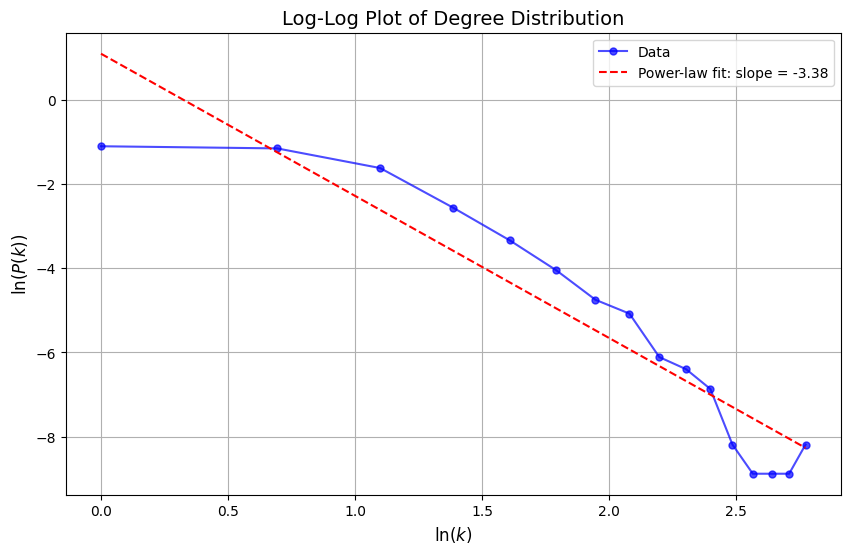

In [21]:
print("For USWI Network")
plot_degree_distribution(G)


For DADA Netwrok


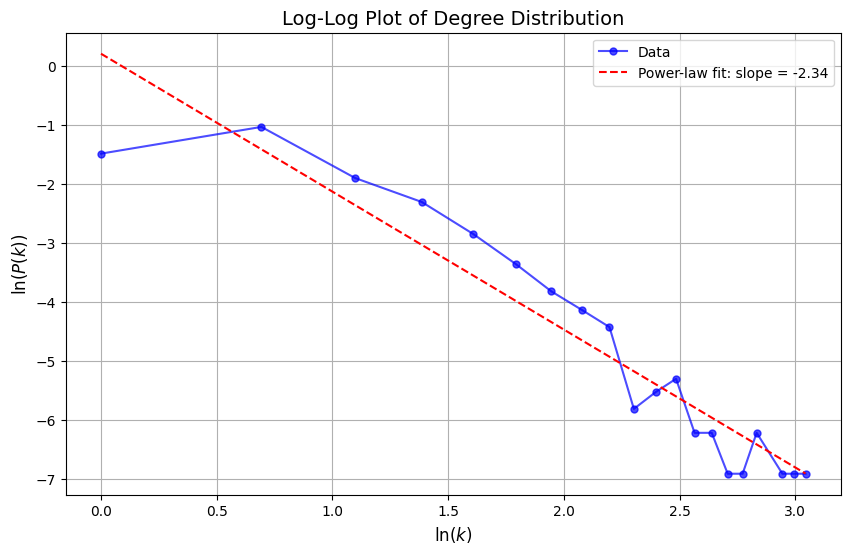

In [22]:
print("For DADA Netwrok")
plot_degree_distribution(dada)

In [23]:
def plot_log_log_line_lengths_distribution(lines):
    """
    Computes and plots the log-log probability distribution of transmission line lengths.

    Parameters:
    - lines: pandas.DataFrame
        A DataFrame containing transmission line data, including the column 'x' representing line lengths.

    Returns:
    - None
    """
    # Ensure line lengths are extracted as a numpy array
    line_lengths = np.array(lines['x'])

    # Step 1: Compute ln(x) (log of line lengths)
    ln_x = np.log(line_lengths)

    # Step 2: Create a histogram of ln(x) for probability density
    hist, bin_edges = np.histogram(ln_x, bins=50, density=True)  # 50 bins for the histogram
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers

    # Step 3: Calculate ln(P(ln(x))) by adding a small value to avoid log(0)
    ln_p_ln_x = np.log(hist + 1e-10)

    # Step 4: Plot ln(x) vs ln(P(ln(x)))
    plt.figure(figsize=(8, 6))
    plt.plot(bin_centers, ln_p_ln_x, 'o-', color='blue', label='Data')

    # Add labels, title, and grid
    plt.xlabel(r"$\ln(x)$ (Log of Transmission Line Lengths)", fontsize=12)
    plt.ylabel(r"$\ln(P(\ln(x)))$ (Log Probability Density)", fontsize=12)
    plt.title("Log-Log Plot of Transmission Line Lengths Probability Distribution", fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()


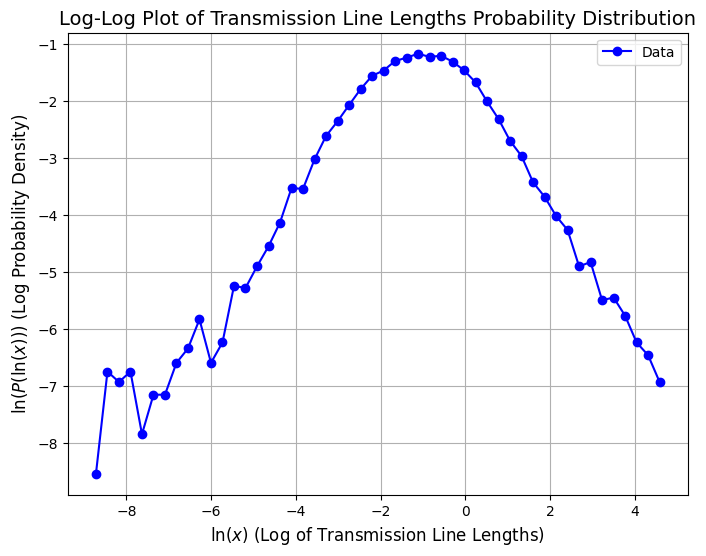

In [24]:
# Call the function to visualize the distribution
plot_log_log_line_lengths_distribution(lines)


In [25]:
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt

def analyze_tails_and_plot(bin_centers, ln_p_ln_x, left_percentile=50, right_percentile=60):
    """
    Analyzes the left and right tails of the log-log probability distribution and plots them.

    Parameters:
    - bin_centers: array-like
        The bin centers of the histogram in log space.
    - ln_p_ln_x: array-like
        The logarithm of the probability density at each bin center.
    - left_percentile: float, optional (default=50)
        Percentile threshold to define the left tail.
    - right_percentile: float, optional (default=60)
        Percentile threshold to define the right tail.

    Returns:
    - None
    """
    # Identify left and right tail indices based on the given percentiles
    left_tail_indices = bin_centers < np.percentile(bin_centers, left_percentile)
    right_tail_indices = bin_centers > np.percentile(bin_centers, right_percentile)

    # Perform linear regression on each tail
    # Left tail
    slope_left, intercept_left, r_value_left, p_value_left, std_err_left = linregress(
        bin_centers[left_tail_indices], ln_p_ln_x[left_tail_indices]
    )

    # Right tail
    slope_right, intercept_right, r_value_right, p_value_right, std_err_right = linregress(
        bin_centers[right_tail_indices], ln_p_ln_x[right_tail_indices]
    )

    # Plot the data and the fitted lines
    plt.figure(figsize=(8, 6))
    plt.plot(bin_centers, ln_p_ln_x, 'o-', color='blue', label='Data')

    # Plot the fitted lines for the left and right tails
    plt.plot(bin_centers[left_tail_indices],
             slope_left * bin_centers[left_tail_indices] + intercept_left,
             'r--', label=f'Left Tail Slope: {slope_left:.2f}')
    plt.plot(bin_centers[right_tail_indices],
             slope_right * bin_centers[right_tail_indices] + intercept_right,
             'g--', label=f'Right Tail Slope: {slope_right:.2f}')

    # Add labels, title, and legend
    plt.xlabel(r"$\ln(x)$ (Log of Transmission Line Lengths)", fontsize=12)
    plt.ylabel(r"$\ln(P(\ln(x)))$ (Log Probability Density)", fontsize=12)
    plt.title("Log-Log Plot of Transmission Line Lengths Probability Distribution with Power-Law Tails", fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the slopes for reference
    print(f"Left tail slope: {slope_left:.2f}")
    print(f"Right tail slope: {slope_right:.2f}")


In [26]:
    # Ensure line lengths are extracted as a numpy array
line_lengths = np.array(lines['x'])

    # Step 1: Compute ln(x) (log of line lengths)
ln_x = np.log(line_lengths)

    # Step 2: Create a histogram of ln(x) for probability density
hist, bin_edges = np.histogram(ln_x, bins=50, density=True)  # 50 bins for the histogram
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers

    # Step 3: Calculate ln(P(ln(x))) by adding a small value to avoid log(0)
ln_p_ln_x = np.log(hist + 1e-10)

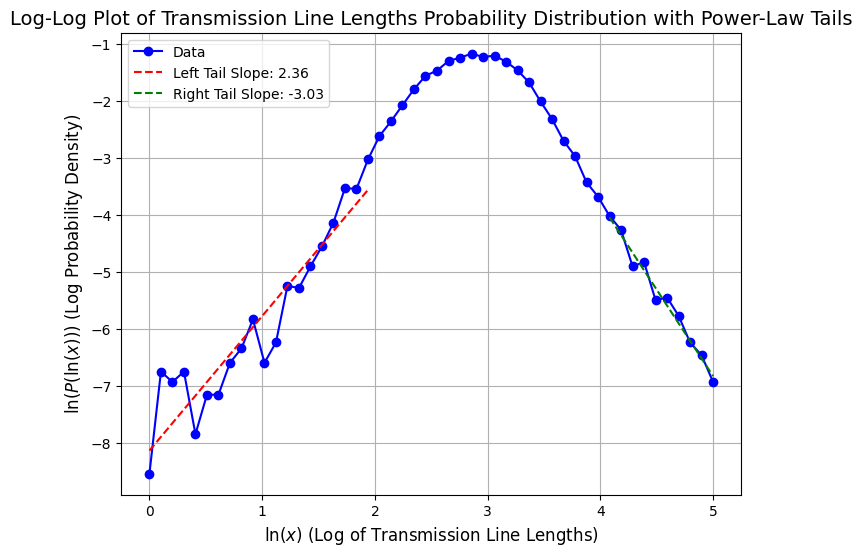

Left tail slope: 2.36
Right tail slope: -3.03


In [27]:
# Call the function to analyze and plot

bin_centers = np.linspace(0, 5, 50)
#for USWI
analyze_tails_and_plot(bin_centers, ln_p_ln_x, left_percentile=40, right_percentile=80)


In [28]:
print("For DADA")


For DADA


In [29]:
lines.head()

,Line Number,Bus 1,Bus 2,x
0,1,14430,13769,0.176627
1,2,14429,13074,0.102980
2,3,14428,14036,0.084389
3,4,14427,14007,0.011286
4,5,14426,12302,0.137005


In [30]:
bus_locations.head()

,Bus Number,Lon,Lat
0,1,-114.808295,33.285811
1,2,-109.168098,45.131739
2,3,-118.686391,36.191126
3,4,-122.776463,49.148646
4,5,-106.566784,45.765771


In [31]:
# Power grid visualization

# Power grid visualization

In [32]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_power_grid(G, output_file="power_grid_network_improved.png"):
    """
    Visualizes the WI-like power grid network with supply and demand nodes highlighted.

    Parameters:
    - G: networkx.Graph
        The power grid graph with node attributes `lon`, `lat`, `supply`, and `demand`.
    - output_file: str
        File name for saving the plot.

    Returns:
    - None
    """
    plt.figure(figsize=(100, 100))  # Set figure size

    # Ensure 'lon' and 'lat' attributes exist for nodes
    pos = {bus: (data.get('lon', 0), data.get('lat', 0)) for bus, data in G.nodes(data=True)}

    # Filter supply nodes and demand nodes based on non-zero positive values
    supply_nodes = [bus for bus, data in G.nodes(data=True) if data.get('supply', 0) > 0]
    demand_nodes = [bus for bus, data in G.nodes(data=True) if data.get('demand', 0) > 0]

    # Set node size based on supply/demand magnitude
    supply_sizes = [data['supply'] * 10 for bus, data in G.nodes(data=True) if bus in supply_nodes]
    demand_sizes = [data['demand'] * 10 for bus, data in G.nodes(data=True) if bus in demand_nodes]

    # Draw the entire network
    nx.draw(
        G,
        pos,
        node_size=30,
        with_labels=False,
        node_color='lightblue',
        alpha=0.5,
        edge_color='gray',
        width=0.5
    )

    # Highlight supply and demand nodes
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=supply_nodes,
        node_size=supply_sizes,
        node_color='green',
        alpha=0.8,
        label='Supply'
    )
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=demand_nodes,
        node_size=demand_sizes,
        node_color='red',
        alpha=0.8,
        label='Demand'
    )

    # Adjust edge weights if 'x' exists; otherwise, use default
    edge_weights = [G[u][v].get('x', 1) for u, v in G.edges()]
    nx.draw_networkx_edges(
        G,
        pos,
        width=edge_weights,
        edge_color='lightgray',
        alpha=0.5
    )

    # Add title and legend
    plt.title("Visualization of WI-like Power Grid Network")
    plt.legend(['Supply', 'Demand'], loc='upper right')

    # Save the plot
    plt.savefig(output_file, dpi=300)

    # Adjust margins and display the plot
    plt.tight_layout()
    plt.show()


In [ ]:
visualize_power_grid(G, output_file="power_grid_network_improved.png")


<ipython-input-32-570ec562bca9>:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [ ]:
def plot_power_grid(G):
    """
    Visualize the power grid using bus locations.
    """
    pos = {node: (G.nodes[node]["lon"], G.nodes[node]["lat"]) for node in G.nodes}
    plt.figure(figsize=(100, 100))
    nx.draw(G, pos, with_labels=True, node_size=30, node_color="blue", edge_color="gray")
    plt.title("Power Grid Visualization")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

# Plot the power grid
plot_power_grid(G)



# Implementation of DC Power flow model

In [ ]:
# Initialize the graph
G = nx.Graph()

# Add nodes with location attributes
for _, row in bus_locations.iterrows():
    G.add_node(row["Bus Number"], lon=row["Lon"], lat=row["Lat"])

# Add edges with reactance (x) as an attribute
for _, row in lines.iterrows():
    G.add_edge(row["Bus 1"], row["Bus 2"], reactance=row["x"])


In [ ]:
# Map supplies and demands to buses
supply_map = dict(zip(supply_values["Bus Number"], supply_values["Supply (MW)"]))
demand_map = dict(zip(demand_values["Bus Number"], demand_values["Demand (MW)"]))

# Add supply and demand attributes to each node
for node in G.nodes:
    G.nodes[node]["supply"] = supply_map.get(node, 0)
    G.nodes[node]["demand"] = demand_map.get(node, 0)


In [ ]:
import random

def simulate_cascading_failures(G, threshold_factor=1.25, subset_size=1):
    """
    Simulate cascading failures on the power grid network for a random subset of edges.

    Parameters:
        G: The graph representing the power grid.
        threshold_factor: Factor to determine the failure threshold for each edge.
        subset_size: Number of edges to randomly choose for simulation.
    """
    # Set failure thresholds for each line
    thresholds = {}
    for u, v, data in G.edges(data=True):
        reactance = data.get("reactance", 0.0)  # Default to 0.0 if reactance is missing
        if isinstance(reactance, dict):
            reactance = reactance.get("value", 0.0)  # Handle nested dictionaries
        if not isinstance(reactance, (int, float)):  # Ensure reactance is numeric
            reactance = 0.0
        thresholds[(u, v)] = reactance * threshold_factor

    # Failures storage
    cascading_failures = []

    # Select a random subset of edges
    edges = list(G.edges)
    selected_edges = random.sample(edges, min(subset_size, len(edges)))

    # Simulate failure of each selected edge
    for edge in selected_edges:
        G.remove_edge(*edge)  # Remove the initial edge to simulate failure
        iteration_failures = []

        while True:
            overloaded_edges = []
            for u, v, data in G.edges(data=True):
                reactance = data.get("reactance", 0.0)  # Default to 0.0 if reactance is missing
                if isinstance(reactance, dict):
                    reactance = reactance.get("value", 0.0)  # Handle nested dictionaries
                if not isinstance(reactance, (int, float)):  # Ensure reactance is numeric
                    reactance = 0.0
                if reactance > thresholds.get((u, v), float('inf')):
                    overloaded_edges.append((u, v))

            if not overloaded_edges:
                break  # Stop if no overloads
            for u, v in overloaded_edges:
                G.remove_edge(u, v)
                iteration_failures.append((u, v))

        cascading_failures.append(iteration_failures)

        # Reset the graph for the next iteration
        G.add_edge(*edge, reactance=thresholds[edge] / threshold_factor)

    return cascading_failures


In [ ]:
import json

# Simulate cascading failures
cascades = simulate_cascading_failures(G)

# Save results to JSON
with open("Cascade.json", "w") as f:
    json.dump(cascades, f)

# Save grid topology to JSON
topology = [{"Bus 1": u, "Bus 2": v, "Reactance": data["reactance"]} for u, v, data in G.edges(data=True)]
with open("Topology.json", "w") as f:
    json.dump(topology, f)


In [ ]:
import json

# Simulate cascading failures
cascades = simulate_cascading_failures(G)

# Ensure cascades data is JSON-serializable
serializable_cascades = [
    [list(edge) for edge in cascade] for cascade in cascades
]

# Save cascading failures to JSON
try:
    with open("Cascade.json", "w") as f:
        json.dump(serializable_cascades, f, indent=4)
    print("Cascades saved to Cascade.json")
except Exception as e:
    print(f"Error saving Cascade.json: {e}")

# Save grid topology to JSON
try:
    topology = [
        {
            "Bus 1": u,
            "Bus 2": v,
            "Reactance": data.get("reactance", None)  # Default to None if reactance is missing
        }
        for u, v, data in G.edges(data=True)
    ]
    with open("Topology.json", "w") as f:
        json.dump(topology, f, indent=4)
    print("Topology saved to Topology.json")
except Exception as e:
    print(f"Error saving Topology.json: {e}")


# Visualizing cascade

In [ ]:
from PIL import Image, ImageSequence
import os


In [ ]:
# Load cascades data
with open("Cascade.json", "r") as f:
    cascades = json.load(f)

# Load topology data
with open("Topology.json", "r") as f:
    topology = json.load(f)

# Create the graph from the topology
G = nx.Graph()
for edge in topology:
    G.add_edge(edge["Bus 1"], edge["Bus 2"], reactance=edge["Reactance"])


In [ ]:
def visualize_cascade(cascades, G, output_dir="frames"):
    """
    Visualize cascading failures as a series of plots.

    Parameters:
    - cascades: list of failure steps from Cascade.json.
    - G: NetworkX graph representing the power grid.
    - output_dir: Directory to save frames for animation.
    """
    os.makedirs(output_dir, exist_ok=True)  # Create directory for saving frames

    for step, failures in enumerate(cascades):
        plt.figure(figsize=(100, 100))
        pos = nx.spring_layout(G, seed=42)  # Use a consistent layout for clarity

        # Highlight failed edges
        edge_colors = [
            "red" if (u, v) in failures or (v, u) in failures else "gray"
            for u, v in G.edges()
        ]
        nx.draw(
            G, pos,
            edge_color=edge_colors,
            node_color="lightblue",
            with_labels=True,
            width=1.5,
            node_size=30
        )

        plt.title(f"Cascade Step {step + 1}", fontsize=16)
        plt.savefig(f"{output_dir}/cascade_step_{step + 1}.png")
        plt.close()

    print(f"Frames saved in {output_dir}/")


In [ ]:
def create_gif_from_frames(output_dir="frames", gif_name="cascade.gif"):
    """
    Create a GIF from a series of saved frames.

    Parameters:
    - output_dir: Directory where frames are saved.
    - gif_name: Name of the output GIF file.
    """
    frames = []
    frame_files = sorted([f for f in os.listdir(output_dir) if f.endswith(".png")])
    for frame_file in frame_files:
        frame_path = os.path.join(output_dir, frame_file)
        frames.append(Image.open(frame_path))

    # Save frames as a GIF
    gif_path = os.path.join(output_dir, gif_name)
    frames[0].save(
        gif_path, save_all=True, append_images=frames[1:], optimize=False, duration=500, loop=0
    )
    print(f"GIF created at {gif_path}")


In [ ]:
# Visualize the cascade and save frames
#visualize_cascade(cascades, G)

# Create a GIF from the frames
#create_gif_from_frames()


# Calculating Metrics

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def calculate_cascade_metrics(cascades, G, initial_demand):
    """
    Calculate cascade severity metrics.

    Parameters:
    - cascades: List of cascade events (each step contains failed edges).
    - G: NetworkX graph representing the grid.
    - initial_demand: Total initial demand (I0).

    Returns:
    - metrics: Dictionary containing the calculated metrics.
    """
    # Cascade duration
    cascade_duration = len(cascades)

    # Number of active lines
    all_edges = set(G.edges())
    failed_edges = set(edge for step in cascades for edge in step)
    active_lines = len(all_edges - failed_edges)

    # Yield at each time step
    yield_at_t = []
    for step in cascades:
        active_demand = sum(
            G.nodes[node].get("demand", 0) for node in G.nodes() if G.degree(node) > 0
        )
        yield_at_t.append(active_demand / initial_demand)
    final_yield = yield_at_t[-1]

    # Local yield (Y(t, h)) and blackout radius of gyration (rB(t))
    local_yield = []
    radius_of_gyration = []
    for t, step in enumerate(cascades):
        failed_nodes = {node for edge in step for node in edge}
        # Blackout radius of gyration
        blackout_nodes = [
            node for node in G.nodes()
            if G.degree(node) == 0 or G.nodes[node].get("demand", 0) == 0
        ]
        distances = [
            np.linalg.norm(np.array([G.nodes[node]["lon"], G.nodes[node]["lat"]]))
            for node in blackout_nodes
        ]
        active_demand = [G.nodes[node].get("demand", 0) for node in blackout_nodes]
        if active_demand:
            rB_t = np.sqrt(
                np.sum(np.array(distances)**2 * np.array(active_demand))
                / np.sum(active_demand)
            )
        else:
            rB_t = 0
        radius_of_gyration.append(rB_t)

        # Placeholder for local yield computation (extendable for different hop distances)
        local_yield.append(0)  # Simplify for now

    metrics = {
        "Cascade Duration": cascade_duration,
        "Active Lines": active_lines,
        "Final Yield": final_yield,
        "Yield at Each Step": yield_at_t,
        "Radius of Gyration at Each Step": radius_of_gyration,
        "Local Yield (Placeholder)": local_yield
    }
    return metrics


In [ ]:
def analyze_yield_bimodality(trials, cascades_function, G, initial_demand):
    """
    Analyze the bimodality of yield distribution over multiple trials.

    Parameters:
    - trials: Number of cascade trials to perform.
    - cascades_function: Function to simulate cascading failures.
    - G: NetworkX graph representing the grid.
    - initial_demand: Total initial demand (I0).

    Returns:
    - None (plots yield histogram and cumulative distribution).
    """
    yields = []
    for _ in range(trials):
        cascades = cascades_function(G)  # Simulate a cascade
        metrics = calculate_cascade_metrics(cascades, G, initial_demand)
        yields.append(metrics["Final Yield"])

    # Histogram of yields
    plt.figure(figsize=(8, 6))
    plt.hist(yields, bins=30, color='blue', alpha=0.7, label="Yield Distribution")
    plt.xlabel("Yield")
    plt.ylabel("Number of Events")
    plt.title("Histogram of Final Yield (Bimodality Analysis)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Cumulative distribution of yields
    sorted_yields = np.sort(yields)
    cumulative = np.cumsum(sorted_yields) / sum(sorted_yields)
    plt.figure(figsize=(8, 6))
    plt.plot(sorted_yields, cumulative, 'r-', label="Cumulative Distribution")
    plt.xlabel("Yield")
    plt.ylabel("Cumulative Distribution")
    plt.title("Cumulative Yield Distribution")
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
for node, data in G.nodes(data=True):
    print(node, data)

In [ ]:
for u, v, data in G.edges(data=True):
    print(u, v, data)
